# Hierarchical Forecasting

# Table Of Contents
[1. Introduction](#1.Introduction)\
[2. Hierarchical Time Series](#2.-Hierarchical_Time_Series)\
[3. Bottom Up](#3.-Bottom_Up)\
[4. Top Down](#4.-Top_Down)\
[5. Middle Out](#5.-Middle_Out)\
[6. Min Trace](#6.-Min_Trace)\
[7. Final Thought](#7.-Final_Thought)


# Introduction
Determining the quantity of camping gear sold by a single store every month throughout the year may appear challenging to those unfamiliar with the process. This type of sales projection, much like predicting the weather, involves utilizing scientific methods and analyzing past data. Inaccurate business forecasts could potentially lead to real or missed opportunities, similar to how an incorrect weather forecast might have lugged around an umbrella on a clear, sunny day.

Hierarchical Time series:
Time series datasets often have complex structures with various levels or hierarchies of aggregation. These hierarchies can include categories, brands, or geographical groupings. To make informed decisions and plans, it is crucial to have consistent and coherent forecasts across these different levels. Hierarchical Forecast provides different reconciliation methods that ensure the forecasts remain coherent across the hierarchies.

Time series in different applications exhibit an inherent hierarchy, known as a level structure. We can have a look at the dia

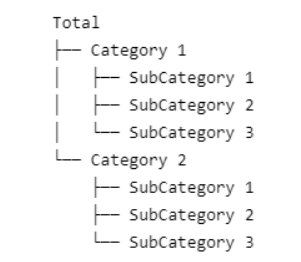

- We have a Total Aggregate, then two Categories, and some Subcategories.
- A hierarchical Time series is about a situation where each subcategory fits uniquely under only one possible node in a tree.
- A hierarchical Time series is about reconciliation, which means producing coherent forecasts and holding a logical relationship as:
- T = C1 + C2
- C1 = SC1 +SC2 + SC3
- C2 = SC4 + SC5
- It's important to note that the Total can not be bigger than the sum of an individual component, and nor should it be smaller.

### The Setup:
For Hierarchical Forecasting, we need to maintain a Setup to ensure the forecast is coherent. For that, we shall break down the Hierarchical Time series into Three components:
#### 1. Base Forecast: 
- To build univariate forecasts at each level across the hierarchy.

#### 2. Summing up Matrix: 
From the  Above Diagram, we can see that there are
   - describes the Hierarchical Structure of the data
   - Columns are the unique series in the bottom level
   - Rows are the unique series across all levels
   - Values i.e. boolean 0/1 in which the column levels categories map to each of the hierarchies across the levels.
From the above diagram, we can see that there are a total of Nine levels:
-  i. One is Total at the higher level as Row(node);
-  ii. Two are Categories in the middle level as in Rows(nodes), and
-  iii. Three Subcategories at the bottom level, are in the columns in the hierarchy that we have to map to the entire summing-up matrix.

#### 3. Mapping Matrix:
- Multiply the Summing Matrix and Base Forecast to generate a Coherent Forecast.
- Reconcile the Forecasts with Variance(The Main Objective).
- These vary with different methods used for reconciliation.

### Data Set(Walmert Sales)
The sales data from Walmart, which is the largest company in the world in terms of revenue, is utilized to predict the daily sales for the upcoming 28 days. This comprehensive dataset encompasses information about various aspects including:
- item level,
- department,
- product categories, and
- store details for stores located in three US States namely:
  
- California,
- Texas, and
- Wisconsin.


Moreover, it also consists of explanatory variables such as:
- price,
- promotions,
- day of the week, and
- special events.

By leveraging this extensive dataset, the accuracy of sales forecasting can be significantly enhancedgram:

### To install the package
The packages of hierarchicalforecast, statsforecast, and datasetsforecast via Python's pip, we may execute the subsequent command in our terminal or command line.

!pip install hierarchicalforecast statsforecast datasetsforecaast

In [3]:
# Library imports
import numpy as np
import pandas as pd
import os


from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import  BottomUp, TopDown, MiddleOut, MinTrace, ERM
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from hierarchicalforecast.evaluation import HierarchicalEvaluation

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') 

C:\Users\Sarmita\anaconda3\Lib\site-packages\statsforecast\core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

In [4]:
# sales data calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])
calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])
calendar_df = calendar_df.loc[:, ['date', 'wm_yr_wk', 'd']]
df = pd.read_csv('sales_train_evaluation.csv')
df = df.loc[df.item_id=='FOODS_3_819']
df_T = df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_T.drop(columns=['id'], inplace=True)

sales_df = df_T.merge(calendar_df, left_on='variable', right_on='d', how='left')
sales_df.rename(columns={'value': 'sales_qty'}, inplace=True)
df = sales_df.loc[sales_df.date >= '2014-01-01', ['date', 'store_id', 'sales_qty']]
df['state_id'] = df['store_id'].str[:2]

df.head(3)

,date,store_id,sales_qty,state_id
10680,2014-01-01,CA_1,3,CA
10681,2014-01-01,CA_2,0,CA
10682,2014-01-01,CA_3,7,CA


In [6]:
#calendar_df.head()

- We need to have a unique hierarchy for the Hierarchical Forecast.
-  Data should be in a long format.

Hence, we can see that the 'date' and 'store_id' are the unique identifiers at the level of the hierarchy.
- we can use group_by() with date and store_id.

In [4]:
# create the long format matrix: individual stores
df_ind = df.groupby(['date', 'store_id'])[['sales_qty']].sum()
df_ind.reset_index(inplace=True)
df_ind = df_ind.T.reset_index(drop=True).T
df_ind.columns = ['ds', 'unique_id', 'sales']

# create the long format matrix: state level
df_sta = df.groupby(['date', 'state_id'])[['sales_qty']].sum()
df_sta.reset_index(inplace=True)
df_sta.columns = ['ds', 'unique_id', 'sales']

# create the long format matrix: total level
df_tot = df.groupby(['date'])[['sales_qty']].sum()
df_tot.reset_index(inplace=True)
df_tot['unique_id'] = 'Total'
df_tot.columns = ['ds', 'sales', 'unique_id' ]

# combine all three
dfx = pd.concat([df_ind, df_sta, df_tot], axis = 0)
print(df_ind.shape, df_sta.shape, df_tot.shape, dfx.shape)

# format
xset = set(dfx.unique_id)
dfx.columns = ['ds','unique_id', 'y']
dfx['ds'] = pd.to_datetime(dfx['ds'])
dfx.head(10)


(8730, 3) (2619, 3) (873, 3) (12222, 3)


,ds,unique_id,y
0,2014-01-01,CA_1,3
1,2014-01-01,CA_2,0
2,2014-01-01,CA_3,7
3,2014-01-01,CA_4,0
4,2014-01-01,TX_1,0
5,2014-01-01,TX_2,1
6,2014-01-01,TX_3,1
7,2014-01-01,WI_1,1
8,2014-01-01,WI_2,0
9,2014-01-01,WI_3,3


### The subsequent stage involves calculating the sum matrix:
- remember that matrix S is an m x n matrix,
- where m represents the number of unique series across all levels (stores + states + total) and
- n represents the number of stores.

In [8]:
# Initialize an empty matrix S with dimensions len(xset) x len([f for f in xset if '_' in f])

xset = ['Total', 'CA', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX', 'TX_1', 'TX_2', 'TX_3', 'WI', 'WI_1', 'WI_2', 'WI_3']



S = np.zeros((len(xset), len([f for f in xset if '_' in f])))


# rows/columns
### All the possible levels in the Hierarchy
list1 = ['Total', 'CA','CA_1','CA_2','CA_3','CA_4','TX','TX_1','TX_2','TX_3','WI','WI_1','WI_2','WI_3']

### Sorted values in the Hierarchy
list2 = ['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']
S = pd.DataFrame(S); S.index = list1; S.columns = list2


# encode the hierarchical structure
S.loc['Total'] = 1
S.loc['CA'][['CA_1','CA_2','CA_3', 'CA_4']] = 1
S.loc['TX'][['TX_1','TX_2','TX_3']] = 1
S.loc['WI'][['WI_1','WI_2','WI_3']] = 1
for x in S.columns:
    S.loc[x][x]= 1
S = S.astype(int)
S

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
Total,1,1,1,1,1,1,1,1,1,1
CA,1,1,1,1,0,0,0,0,0,0
CA_1,1,0,0,0,0,0,0,0,0,0
CA_2,0,1,0,0,0,0,0,0,0,0
CA_3,0,0,1,0,0,0,0,0,0,0
CA_4,0,0,0,1,0,0,0,0,0,0
TX,0,0,0,0,1,1,1,0,0,0
TX_1,0,0,0,0,1,0,0,0,0,0
TX_2,0,0,0,0,0,1,0,0,0,0
TX_3,0,0,0,0,0,0,1,0,0,0


The entire summation matrix is a Binary matrix, where for the total we have a row of 1's. That means every single row needs to add up to form the total.
- Category 1: contain 1's when the sub-categories are there and form it at the time of aggregation, and 0's for others.
- Category 2: As we can see from the diagram sub-category 1 and sub-category 2 do not belong to this, contain 0's, and 3, 4, and 5 contain 1's.


- tags: Initially is an empty dictionary that maintains the logical order of the levels.
Now, it's the time to encode what belongs to which matrix and in logical order.

In [6]:
tags = {}
tags['Country'] = np.array(['Total'], dtype=object)
tags['Country/State'] = np.array(['CA', 'TX', 'WI'], dtype=object)
tags['Country/State/Store'] = np.array(['CA_1', 'CA_2', 'CA_3', 'CA_4',  
                                        'TX_1', 'TX_2', 'TX_3',
                                        'WI_1', 'WI_2', 'WI_3'], dtype=object)
tags

{'Country': array(['Total'], dtype=object),
 'Country/State': array(['CA', 'TX', 'WI'], dtype=object),
 'Country/State/Store': array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
        'WI_2', 'WI_3'], dtype=object)}

In [7]:
horizon = 7 

x_test = dfx.groupby('unique_id').tail(horizon)
x_train = dfx.drop(x_test.index)
x_test = x_test.set_index('unique_id')
x_train = x_train.set_index('unique_id')

In [8]:
# If unique_id is currently the index, reset the index
x_train = x_train.reset_index()

# Ensure unique_id is a column
x_train['unique_id'] = x_train['unique_id'].astype(str)

In [9]:
import pandas as pd
x_train['ds'] = pd.to_datetime(x_train['ds'], errors='coerce')

# Drop rows where 'ds' could not be parsed
x_train = x_train.dropna(subset=['ds'])


# Assuming x_train is our DataFrame
x_train['y'] = pd.to_numeric(x_train['y'], errors='coerce')

# Optionally dropping rows with missing values
x_train.dropna(subset=['ds', 'y'], inplace=True)

In [10]:
print(x_train.dtypes)
print(x_train.head())

unique_id            object
ds           datetime64[ns]
y                     int64
dtype: object
  unique_id         ds  y
0      CA_1 2014-01-01  3
1      CA_2 2014-01-01  0
2      CA_3 2014-01-01  7
3      CA_4 2014-01-01  0
4      TX_1 2014-01-01  0


In [11]:
import pandas as pd
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA

# Initialize StatsForecast
models = [AutoARIMA()]
sf = StatsForecast(models=models, freq='D')

# Fit the model
sf.fit(x_train)

# Predict
forecast_df = sf.predict(h=7)
print(forecast_df)

                  ds  AutoARIMA
unique_id                      
CA        2016-05-16   6.236943
CA        2016-05-17   6.033696
CA        2016-05-18   6.033696
CA        2016-05-19   6.033696
CA        2016-05-20   6.033696
...              ...        ...
WI_3      2016-05-18   1.885268
WI_3      2016-05-19   1.885268
WI_3      2016-05-20   1.885268
WI_3      2016-05-21   1.885268
WI_3      2016-05-22   1.885268

[98 rows x 2 columns]


C:\Users\Sarmita\anaconda3\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [12]:
xmat = pd.merge(left = x_test, right = forecast_df, on = ['ds', 'unique_id'])
xmat.head(3)

,ds,y,AutoARIMA
unique_id,,,
CA_1,2016-05-16,2,2.128186
CA_2,2016-05-16,0,1.512053
CA_3,2016-05-16,1,1.699377


In [13]:
xmat = pd.merge(left = x_test, right = forecast_df, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred']]
print('overall rmse: ' + str(my_rmse(xmat['y'], xmat['pred'])))
for k in tags.keys():
    print(k + ' rmse: ' + str(my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred'])))

overall rmse: 2.1359
Country rmse: 4.8227
Country/State rmse: 2.3625
Country/State/Store rmse: 1.5448


# Bottom Up:
- Forecasts generated at the Bottom level and then aggregated them.
- Makes the process as consistent as possible.
- A list of methods 'HierarchicalReconciliation' are used for the reconciliation.
- Then instantiate a hierarchical Reconciliation object.

In [14]:
# Reconcile the base predictions
reconcilers = [
    BottomUp()
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

#x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(forecast_df, S, tags)

In [16]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='AutoARIMA')

,,AutoARIMA,AutoARIMA/BottomUp
level,metric,,
Overall,mse-scaled,1.0,1.035249
Country,mse-scaled,1.0,1.104742
Country/State,mse-scaled,1.0,0.988961
Country/State/Store,mse-scaled,1.0,1.0


In [17]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.head(3)

,ds,y,AutoARIMA,AutoARIMA/BottomUp
unique_id,,,,
CA_1,2016-05-16,2,2.128186,2.128186
CA_2,2016-05-16,0,1.512053,1.512053
CA_3,2016-05-16,1,1.699377,1.699377


In [18]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 2.1359 -> 2.1732
Country rmse: 4.8227 -> 5.0689
Country/State rmse: 2.3625 -> 2.3495
Country/State/Store rmse: 1.5448 -> 1.5448


# TOP Down:
- The Process is the same but in the opposite direction.
- Disaggregate based on the proportion.

In [20]:
# Reconcile the base predictions
reconcilers = [
    TopDown(method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(forecast_df, S, tags)

In [21]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='AutoARIMA')

,,AutoARIMA,AutoARIMA/TopDown_method-forecast_proportions
level,metric,,
Overall,mse-scaled,1.0,1.00909
Country,mse-scaled,1.0,1.0
Country/State,mse-scaled,1.0,1.005128
Country/State/Store,mse-scaled,1.0,1.020729


In [22]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 2.1359 -> 2.1456
Country rmse: 4.8227 -> 4.8227
Country/State rmse: 2.3625 -> 2.3686
Country/State/Store rmse: 1.5448 -> 1.5608


# Middle Out:
- This Forecast combines the above two approaches.
- Picks a middle level.
- Uses Bottom_Up to find the overall sales.
- Disintegrate sales using proportion 'Top Down' at the most granular level.

In [24]:
# Reconcile the base predictions
reconcilers = [
    MiddleOut(middle_level = 'Country/State', top_down_method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags).fillna(0)
x_hat_rec = hrec.reconcile(forecast_df, S, tags).fillna(0)

In [25]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='AutoARIMA')

,,AutoARIMA,AutoARIMA/MiddleOut_middle_level-Country/State_top_down_method-forecast_proportions
level,metric,,
Overall,mse-scaled,1.0,1.006364
Country,mse-scaled,1.0,0.996426
Country/State,mse-scaled,1.0,1.0
Country/State/Store,mse-scaled,1.0,1.020515


In [26]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 2.1359 -> 2.1427
Country rmse: 4.8227 -> 4.814
Country/State rmse: 2.3625 -> 2.3625
Country/State/Store rmse: 1.5448 -> 1.5606


# Min Trace:
- Predict for all the levels independently.
- Construct a mapping matrix
- This mapping matrix minimizes the overall variance.
- Assume that the forecasts are unbiased.


In [29]:
# Reconcile the base predictions
reconcilers = [
    MinTrace(method='ols'),
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(forecast_df, S, tags)

In [30]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='AutoARIMA')

,,AutoARIMA,AutoARIMA/MinTrace_method-ols
level,metric,,
Overall,mse-scaled,1.0,0.99678
Country,mse-scaled,1.0,1.003602
Country/State,mse-scaled,1.0,0.984885
Country/State/Store,mse-scaled,1.0,0.998478


In [31]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )

overall rmse: 2.1359 -> 2.1324
Country rmse: 4.8227 -> 4.8313
Country/State rmse: 2.3625 -> 2.3446
Country/State/Store rmse: 1.5448 -> 1.5437


# Final Thought
Creating accurate forecasts for large collections of time series organized into structures at different aggregation levels can be a challenging task. One of the main challenges is ensuring that the forecasts adhere to the aggregation constraints of the data. To address this challenge, HierarchicalForecast provides a range of reconciliation methods such as BottomUp, TopDown, MiddleOut, and MinTrace. Additionally, it offers probabilistic coherent predictions like Normality, Bootstrap, etc. These methods and techniques aim to generate forecasts that are both accurate and consistent with the hierarchical structure of the data.